In [31]:
using Revise
using AvailablePotentialEnergyFramework, NCDatasets, Statistics, AbstractPlotting, CairoMakie

In [36]:
exp_name = "f5e-4_2km_1000km_homoRad_nonudge"
outputfile = string("/global/cscratch1/sd/aramreye/for_postprocessing/ApeBudgetOutputs_50days/",exp_name)
input_folder = "/global/cscratch1/sd/aramreye/for_postprocessing/largencfiles/"
file2d = string(input_folder,exp_name,"_2d.nc")
file3d = string(input_folder,exp_name,"_3d.nc")
total_days = 5
offset_in_days = 20
output_timestep = 7200 #seconds
indices_in_part = 60
indices_in_day = 86400 ÷ output_timestep
number_of_parts = total_days*indices_in_day÷indices_in_part
positionn = 1
part_number = 1
initial_timestep = offset_in_days*indices_in_day + indices_in_part*(part_number-1) + 1
final_timestep = offset_in_days*indices_in_day + indices_in_part*(part_number)
@info "Starting part $part_number with indices from" initial_timestep final_timestep
#getapeanalysis(file2d,file3d,outputfile,initial_timestep,final_timestep,part_number,output_timestep,position,Float32)

┌ Info: Starting part 1 with indices from
│   initial_timestep = 241
│   final_timestep = 300
└ @ Main In[36]:16


In [37]:
@info "Starting APE analysis routine"
    const day           = 86400
    const sst           = 300
    const dt            = output_timestep    
    const dayLength     = 60*60*24÷output_timestep; #How many data points make one day

    const Pref          = 1000*1e2                 #Pa
    const Ts            = sst                      #Sea surface temperature
    const qs            = 25.7*1e-3 
    const Tvs           = Ts*(1+epsilon*qs)
    const c1            = (Dryair.R/Dryair.cp)
    const smooth_x      = smooth_y = 15 #it was 11
    const smooth_time   = floor(Int,dayLength*5)+1 

    iterator_time_2d    = initial_timestep*2-1:2:(final_timestep)*2  
    iterator_time_3d    = initial_timestep:1:final_timestep


┌ Info: Starting APE analysis routine
└ @ Main In[37]:1


241:1:300

In [84]:
ds3d                = Dataset(file3d)
    ds2d                = Dataset(file2d)
    x                   = variable(ds3d,"x")[:]    :: Array{Float32,1}
    y                   = variable(ds3d,"y")[:]    :: Array{Float32,1}
    z                   = variable(ds3d,"z")[:]    :: Array{Float32,1}
    t                   = variable(ds3d,"time")[iterator_time_3d] :: Array{Float32,1}
    P0                  = variable(ds3d,"p")[:]    :: Array{Float32,1}
    U                   = variable(ds3d,"U")[:,:,:,iterator_time_3d] :: Array{Float32,4}
    @info "Read 10%"    
    V                   = variable(ds3d,"V")[:,:,:,iterator_time_3d] :: Array{Float32,4}
    @info "Read 20%"    
    W                   = variable(ds3d,"W")[:,:,:,iterator_time_3d] :: Array{Float32,4}
    @info "Read 30%"    
    RAD                 = variable(ds3d,"QRAD")[:,:,:,iterator_time_3d] :: Array{Float32,4}
    @info "Read 40%"    
    T                   = variable(ds3d,"TABS")[:,:,:,iterator_time_3d] :: Array{Float32,4}
    @info "Read 50%"    
    Tv                  = variable(ds3d,"QV")[:,:,:,iterator_time_3d] :: Array{Float32,4}
    @info "Read 60%"    
    PP                  = variable(ds3d,"PP")[:,:,:,iterator_time_3d] :: Array{Float32,4}
    @info "Read 70%"                  
    SHF                 = variable(ds2d,"SHF")[:,:,iterator_time_2d] :: Array{Float32,3}
    @info "Read 80%"                 
    LHF                 = variable(ds2d,"LHF")[:,:,iterator_time_2d] :: Array{Float32,3}
    @info "Read 90%"

    close(ds3d)   
    close(ds2d)   

┌ Info: Read 10%
└ @ Main In[84]:9
┌ Info: Read 20%
└ @ Main In[84]:11
┌ Info: Read 30%
└ @ Main In[84]:13
┌ Info: Read 40%
└ @ Main In[84]:15
┌ Info: Read 50%
└ @ Main In[84]:17
┌ Info: Read 60%
└ @ Main In[84]:19
┌ Info: Read 70%
└ @ Main In[84]:21
┌ Info: Read 80%
└ @ Main In[84]:23
┌ Info: Read 90%
└ @ Main In[84]:25


closed NetCDF NCDataset

In [85]:
@. SHF    = g/(1*Dryair.cp*Ts)*(SHF)                            
@. LHF    = g/(1*Dryair.cp*Ts)*(epsilon*Dryair.cp*Ts/Liquidwater.Lv*LHF) 
@. SHF    +=  LHF     # Now it is transformed
    
ThetaV       = similar(T)
xBar_Pt      = Array{eltype(ThetaV),4}(undef,1,1,size(PP,3),size(PP,4))
xBar_Tv      = Array{eltype(ThetaV),4}(undef,1,1,size(Tv,3),size(Tv,4))
xBar_ThetaV  = Array{eltype(ThetaV),4}(undef,1,1,size(ThetaV,3),size(ThetaV,4));

In [86]:
 dx           = x[2]-x[1]
    dy           = y[2]-y[1]                            # Grid size
    kz           = length(z)                            # vertical levels
    kx           = length(x)                            # # of horizonal grid points
    ky           = length(y)                            # # of horizonal grid points
    @.  RAD      = RAD/day                              # K/s #Heating rate per second
    @.  Tv       = (1f0 + 1f-3*epsilon*Tv)*T              # Virtual temperature
    @.  P0       = P0*1f2
    PP          .= PP .+ reshape(P0,(1,1,kz,1))
    ThetaV      .= Tv.*(P0[1]./PP).^c1 # Virtual potential temp
    mean!(xBar_Pt,PP)                                     
    mean!(xBar_Tv,Tv)              
    mean!(xBar_ThetaV,ThetaV)   
    var_Tv       =  Tv     .- xBar_Tv
    var_ThetaV   =  ThetaV .- xBar_ThetaV
    rho0         = dropdims(xBar_Pt./R./xBar_Tv,dims=(1,2))
    B            = g .* var_ThetaV./xBar_ThetaV
    @. RAD       = RAD*(g/xBar_Tv)                    # convert unit to buoyancy
    PP           = []

Any[]

In [153]:
function compute_N2_new(xBar_Tv,z)
    T = typeof(g/z[1])
    N2 = zeros(T,length(z),size(xBar_Tv,4))
    factor = (g/Dryair.cp)
    @views N2[1:end-1,:]  .= g .* ( (xBar_Tv[1,1,2:end,:] .- xBar_Tv[1,1,1:end-1,:]) ./(z[2:end] .- z[1:end-1]) .+ factor) ./ xBar_Tv[1,1,1:end-1,:]
    @views N2[end,:]      .= N2[end-1,:]
    for _ in 1:10
    ind_smallN2 = sort!(findall(abs.(N2) .< 1e-4), by = x -> x[1], rev = true)
        @show length(ind_smallN2)
    one_z = CartesianIndex(1,0)
    @inbounds for ind in ind_smallN2
        if 1 < ind[1] < length(z)
           N2[ind] =  (N2[ind + one_z] + N2[ind])/2 # If N2 is small, substite by mean of neighbours
        elseif ind[1] == 1
           N2[ind] = (N2[ind + one_z] + N2[ind])/2
        elseif ind[1] == length(z)
            N2[ind] = N2[ind - one_z]
        end
    end
    end
    return N2
end

compute_N2_new (generic function with 1 method)

In [154]:
    N2           = compute_N2_new(xBar_Tv,z)
    LHF        = []
    T          = []
    ThetaV     = []
    Tv         = []
    var_ThetaV = []
    var_Tv     = []

length(ind_smallN2) = 1355
length(ind_smallN2) = 1226
length(ind_smallN2) = 1192
length(ind_smallN2) = 1165
length(ind_smallN2) = 1130
length(ind_smallN2) = 1097
length(ind_smallN2) = 1072
length(ind_smallN2) = 1040
length(ind_smallN2) = 1015
length(ind_smallN2) = 989


Any[]

In [125]:
dz          = 50
@info size(B), size(RAD), size(SHF), size(U),size(V) ,size(W), size(N2), size(dx),size(dy), size(dz), size(dt), size(x),size(y), size(z), size(t)
Diabatic_other = get_diabatic_as_residual_buoyancy(B, RAD, SHF, U,V ,W, N2, dx,dy, dz, dt);

┌ Info: ((512, 512, 80, 60), (512, 512, 80, 60), (512, 512, 60), (512, 512, 80, 60), (512, 512, 80, 60), (512, 512, 80, 60), (80, 60), (), (), (), (), (512,), (512,), (80,), (60,))
└ @ Main In[125]:2


In [126]:
GC.gc()

In [127]:
z_up        = tropopause_height = 15000
z_BL        = 2000

2000

In [155]:
N2_positive = abs.(N2)
N2_positive == (N2)

false

In [129]:
(int_mass,
     int_KE,
     int_APE,
     int_APE_rate,
     int_APE_Ub2,
     int_APE_Vb2,
     int_APE_WN2,
     int_APE_RAD,
     int_APE_DIA,
     xBar_APE_Fs,
     residual) =  getapebudget(B, U,V, W, N2, RAD, SHF, Diabatic_other, rho0, x,y, z, t, dx,dy, dz, dt, z_up)

┌ Info: Sizes: 
│   size(B) = (512, 512, 80, 60)
│   size(N2) = (1, 1, 80, 60)
│   size(Fs) = (512, 512, 60)
└ @ AvailablePotentialEnergyFramework /global/homes/a/aramreye/.julia/packages/AvailablePotentialEnergyFramework/GbGz5/src/apebudgets.jl:305
┌ Info: (1, 1, 60)
└ @ AvailablePotentialEnergyFramework /global/homes/a/aramreye/.julia/packages/AvailablePotentialEnergyFramework/GbGz5/src/apebudgets.jl:306


(Float32[8791.913, 8790.763, 8789.607, 8788.125, 8787.244, 8785.883, 8785.038, 8783.821, 8782.933, 8782.056  …  8766.106, 8766.202, 8766.418, 8766.535, 8766.282, 8766.675, 8766.772, 8767.185, 8767.713, 8768.307], Float32[609465.06, 597566.8, 590092.2, 592363.8, 580794.25, 579256.0, 568080.25, 570162.75, 562127.2, 554020.75  …  388427.72, 386649.3, 386957.12, 382567.03, 381952.97, 371772.78, 367519.75, 361768.34, 353241.06, 349467.78], Float32[209155.33, 208844.8, 176161.7, 182861.97, 211953.28, 180605.42, 189158.08, 194432.39, 176225.86, 175048.06  …  173092.47, 169125.75, 161588.28, 135511.23, 156555.0, 185461.34, 138559.31, 141151.73, 143495.88, 149154.81], Float32[-0.03930478, -4.535388, 0.9354081, 4.04354, -4.3495626, 1.1905653, 0.7362116, -2.5258455, -0.16090424, -2.6029682  …  -0.5512081, -1.0472896, -3.6219425, 2.9233856, 4.0142093, -6.5143304, 0.35911548, 0.32434767, 0.78469527, 0.7846155], Float32[-5.4419417, -2.827234, -3.0597422, -2.8384044, -2.7309332, -2.232572, -0.0983338

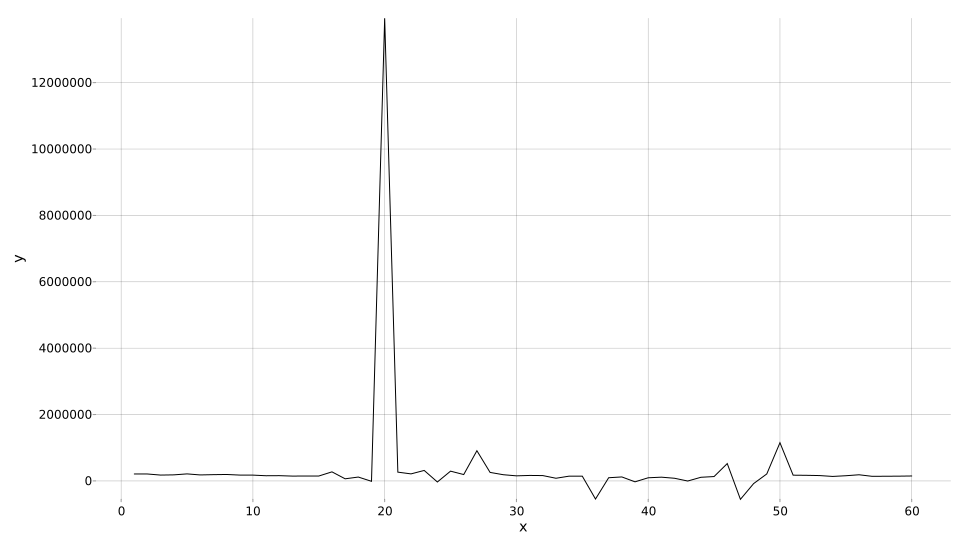

In [156]:
lines(int_APE)

In [158]:
count(int_APE .< 0)

7

In [ ]:
a = heatmap((N2 .< 0)')

In [66]:
mean(N2,dims=2)

80×1 Matrix{Float32}:
 -0.00011726318
 -4.5403016f-5
 -1.836081f-5
 -7.96422f-6
 -3.181649f-6
  1.7201572f-6
  6.3770653f-6
  1.2307018f-5
  1.8686434f-5
  2.6117401f-5
  3.3086664f-5
  4.2344793f-5
  5.110639f-5
  ⋮
  0.0004737573
  0.00049515214
  0.00047884544
  0.00045558464
  0.00043433072
  0.00043662966
  0.0004452471
  0.00044595648
  0.0004457855
  0.0004470087
  0.0004467008
  0.0004467008

In [65]:
lines(mean(N2,dims=2))

LoadError: You are using a matrix for vertices which uses neither dimension to encode the dimension of the space. Please have either size(verts, 1/2) in the range of 2-3. Found: (80, 1)